## Import necessary libraries and function

In [2]:
import pandas as pd
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [3]:
sys.path.append('/home/khanalp/code/PhD/utils')
from utils import read_csv_file_with_station_name
from utils import get_lai_data,calculate_vapor_pressure, calculate_specific_humidity_mixing_ratio
from unit_conversion import celsius_to_kelvin,hectopascal_to_pascal,precipitation_mm_to_kg_m2_s,pascal_to_hectoPascal,kelvin_to_celsius,kilopascal_to_hectoPascal


In [4]:
# Paths to different files
insitu_file_ICOS = "/home/khanalp/data/ICOS2025/IT-Ren/ICOSETC_IT-Ren_FLUXNET_HH_L2.csv"
station_details = '/home/khanalp/code/PhD/preprocessICOSdata/csvs/02_station_with_elevation_heightcanopy.csv'
lai_modis_path = "/home/khanalp/data/processed/lai/modis/v0"
output_directory = "/home/khanalp/data/processed/input_pystemmus/v2"
insitu_file_meteo = "/home/khanalp/data/ICOS2025/IT-Ren/ICOSETC_IT-Ren_METEO_L2.csv"

## Station details

In [5]:
station = "IT-Ren"
start_date = "2022-01-01 00:00:00"
end_date = "2022-12-31 23:30:00"

## Insitu data processing to get in the format pystemmus reads

In [6]:
# Read insitu full file
df_insitu_fluxnet = pd.read_csv(insitu_file_ICOS)
df_insitu_meteo = pd.read_csv(insitu_file_meteo)

In [6]:
 # Assign datetime coordinates to the 'index' dimension based on the 'TIMESTAMP_START' column
df_insitu_fluxnet['time'] = pd.to_datetime(df_insitu_fluxnet['TIMESTAMP_START'], format='%Y%m%d%H%M')
df_insitu_fluxnet.set_index('time', inplace=True)
df_insitu_meteo['time'] = pd.to_datetime(df_insitu_meteo['TIMESTAMP_START'], format='%Y%m%d%H%M')
df_insitu_meteo.set_index('time', inplace=True)

In [7]:
# Replace -9999 with NaN in the DataFrame
df_insitu_fluxnet.replace(-9999, np.nan, inplace=True)
df_insitu_meteo.replace(-9999, np.nan, inplace=True)

In [8]:
df_insitu_fluxnet = df_insitu_fluxnet.loc[start_date:end_date]
df_insitu_meteo = df_insitu_meteo.loc[start_date:end_date]

In [9]:
# Define the list of variables to select from ICOS data
selected_variables = [
    'TA_F',
    'TA_F_QC',
    'SW_IN_F',
    'SW_IN_F_QC',
    'LW_IN_F',
    'LW_IN_F_QC',
    'VPD_F',
    'VPD_F_QC',
    'PA_F',
    'PA_F_QC',
    'P_F',
    'P_F_QC',
    'WS_F',
    'WS_F_QC',
    'RH',
    'CO2_F_MDS',
    'CO2_F_MDS_QC'
]

In [10]:
# Define the mapping for renaming variables
rename_mapping = {
    'TA_F': 'Tair',
    'TA_F_QC': 'Tair_qc',
    'SW_IN_F': 'SWdown',
    'SW_IN_F_QC': 'SWdown_qc',
    'LW_IN_F': 'LWdown',
    'LW_IN_F_QC': 'LWdown_qc',
    'VPD_F': 'VPD',
    'VPD_F_QC': 'VPD_qc',
    'PA_F': 'Psurf',
    'PA_F_QC': 'Psurf_qc',
    'P_F': 'Precip',
    'P_F_QC': 'Precip_qc',
    'WS_F': 'Wind',
    'WS_F_QC': 'Wind_qc',
    'CO2_F_MDS': 'CO2air',
    'CO2_F_MDS_QC': 'CO2air_qc'
}

In [11]:
# Load station details from CSV
df_station_details = pd.read_csv(station_details)

In [12]:
# Read station info to add in the ds_forcing files.
station_info = df_station_details[df_station_details['station_name'] == station]

In [13]:
# Initialize an empty DataFrame to hold selected variables
df_forcing = pd.DataFrame()

In [14]:
# Iterate over the list of selected variables
for var in selected_variables:
    # Check if the variable exists in the input DataFrame
    if var in df_insitu_fluxnet.columns:
        # If the variable exists, add it to the df_selected DataFrame
        df_forcing[var] = df_insitu_fluxnet[var]
    else:
        # If the variable does not exist, add it with missing values (-9999)
        df_forcing[var] = np.full_like(df_forcing.index, -9999)
        # Optional: Uncomment the line below to print a warning message
        # print(f"Variable '{var}' not found in the DataFrame. Adding it with missing values (-9999).")

In [42]:
# Rename columns according to the provided mapping
df_forcing = df_forcing.rename(columns=rename_mapping)

In [43]:
# Convert thet DataFrame to an xarray ds_forcing
ds_forcing = xr.Dataset.from_dataframe(df_forcing)

# Expand dimensions to include 'x' and 'y' coordinates with dummy values
ds_forcing = ds_forcing.expand_dims({'x': [1], 'y': [2]})

# Ensurae 'x' and 'y' coordinates are of type sfloat64 for consistency
ds_forcing['x'] = ds_forcing['x'].astype('float64')
ds_forcing['y'] = ds_forcing['y'].astype('float64')


In [44]:
counts_nan = {var: np.isnan(ds_forcing[var].values).sum() for var in ds_forcing.data_vars}
counts_nan


{'Tair': 0,
 'Tair_qc': 0,
 'SWdown': 0,
 'SWdown_qc': 0,
 'LWdown': 0,
 'LWdown_qc': 0,
 'VPD': 0,
 'VPD_qc': 0,
 'Psurf': 0,
 'Psurf_qc': 0,
 'Precip': 0,
 'Precip_qc': 0,
 'Wind': 0,
 'Wind_qc': 0,
 'RH': 1248,
 'CO2air': 0,
 'CO2air_qc': 0}

# No NaN files, no need to handle data gaps missing.

# Add LAI data in the insitu forcing.

In [45]:
common_start_date,common_end_date,lai = get_lai_data(station_name=station,
                                           start_date=ds_forcing.time.values.min(),
                                           end_date=ds_forcing.time.values.max(),
                                           lai_modis_path=lai_modis_path)

# Add other station details

In [46]:
# Check if the lengths match
if len(lai) != len(ds_forcing['time']):
    raise ValueError("Length mismatch between LAI data and xarray time dimension")

# Add LAI data to ds_forcing
ds_forcing['LAI'] = xr.DataArray(lai.reshape(1, 1, -1), dims=['x', 'y', 'time'])
ds_forcing['LAI_alternative'] = xr.DataArray(lai.reshape(1, 1, -1), dims=['x', 'y', 'time'])

ds_forcing['latitude'] = xr.DataArray(np.array(station_info['latitude']).reshape(1,-1), dims=['x','y'])
ds_forcing['longitude'] = xr.DataArray(np.array(station_info['longitude']).reshape(1,-1), dims=['x','y'])
ds_forcing['reference_height'] = xr.DataArray(np.array(station_info['measurement_height']).reshape(1,-1), dims=['x','y'])
ds_forcing['canopy_height'] = xr.DataArray(np.array(station_info['height_canopy_field_information']).reshape(1,-1), dims=['x','y'])
ds_forcing['elevation'] = xr.DataArray(np.array(station_info['elevation']).reshape(1,-1), dims=['x','y'])
ds_forcing['IGBP_veg_short'] = xr.DataArray(np.array(station_info['IGBP_short_name'], dtype = 'S200').reshape(1,-1),dims = ['x','y'])
ds_forcing['IGBP_veg_long'] = xr.DataArray(np.array(station_info['IGBP_long_name'], dtype = 'S200').reshape(1,-1),dims = ['x','y'])

# ADD RH (which contains some part missing, even though not indexed as -9999 in the data) and Qair is missing in the fluxnet file style.

In [47]:
actual_vapor_pressure = kilopascal_to_hectoPascal(calculate_vapor_pressure(temperatures=(ds_forcing['Tair'].values.flatten())))

array_RH = (1- (ds_forcing['VPD'].values.flatten()/actual_vapor_pressure)) * 100
ds_forcing['RH'] = xr.DataArray(array_RH.reshape(ds_forcing['RH'].shape), dims=ds_forcing['RH'].dims, coords=ds_forcing['RH'].coords)

# ds_veenkampen = update_co2_data(ds_forcing=ds_veenkampen, cams_path=cams_path,counts=nan_occurrence_lengths)
#Some final processing 
ds_forcing['RH'] = ds_forcing['RH'].clip(min=0, max=100)
ds_forcing['VPD'] =  ds_forcing['VPD'].clip(min=0)


# ds_forcing = update_humidity_data(ds_forcing, counts)
# Convert units in the xarray dataset
# ds_forcing = convert_units(ds_forcing)
    # Calculate specific humidity and mixing ratio from actual vapor pressure and air pressure. Note: Presusure in kPa, ea in hPa
specific_humidity, mixing_ratio = calculate_specific_humidity_mixing_ratio(ea=actual_vapor_pressure, 
                                                                            pressure = ds_forcing['Psurf'].values.flatten())
ds_forcing['Qair'] = xr.DataArray(specific_humidity.reshape(1, 1, -1), dims=['x', 'y', 'time'])
ds_forcing['Qair'] = ds_forcing['Qair'].clip(min=0)


# Some final unit conversion

In [48]:

# Convert temperature in celsius to kelvin (for only data from 2021)
ds_forcing['Tair'] = xr.DataArray(celsius_to_kelvin(ds_forcing['Tair'].values).reshape(1, 1, -1), dims=['x', 'y', 'time'])
# Convert precipitation from mm/30 min to mm/s
ds_forcing['Precip'] = ds_forcing['Precip'] / (30 * 60)
ds_forcing['Psurf'] = xr.DataArray((hectopascal_to_pascal(kilopascal_to_hectoPascal(ds_forcing['Psurf'].values.flatten()))).reshape(1, 1, -1), dims=['x', 'y', 'time'])

# Ensure everything to be in float32, otherwise pystemmus won't read.

In [49]:
# Ensure all variables are in float32 format except for specific ones
for var_name in ds_forcing.data_vars:
    if var_name not in ['IGBP_veg_short', 'IGBP_veg_long']:
        ds_forcing[var_name] = ds_forcing[var_name].astype('float32')

# See if any inputs are missing. 

In [50]:
# Check for missing values in variables (excluding those with '_qc')
data_vars_without_qc = [var_name for var_name in ds_forcing.data_vars if '_qc' not in var_name]
no_missing_values = True

In [51]:
# Print missing value status for each variable
for var_name in data_vars_without_qc:
    has_missing_values = ds_forcing[var_name].isnull().any()
    if has_missing_values:
        print(f"Variable '{var_name}' has missing values.")
        no_missing_values = False


# If not any data missing, save the file. 

In [64]:

# Save the ds_forcing if there are no missing values
if no_missing_values:
    # Extract start and end years from the time coordinates
    time_pd = pd.to_datetime(ds_forcing.time.values)
    start_year = time_pd.min().year
    end_year = time_pd.max().year
    
    # Construct the filename for saving the dataset
    filename = f"FLX_{station}_FLUXNET2015_FULLSET_{start_year}-{end_year}.nc"
    output_path = os.path.join(output_directory, filename)
    
    # Save the xarray dataset to NetCDF file
    ds_forcing.to_netcdf(output_path)
    print("Dataset saved successfully.")
else:
    print("There are missing values in one or more variables. Dataset not saved.")


Dataset saved successfully.


## Plotting to check if every data is correct, within the range.

In [52]:
# Define the variables to plot
variables_to_plot = ['Tair', 'SWdown', 'LWdown', 'VPD', 'Psurf', 'Precip', 'Wind', 'RH', 'CO2air', 'LAI']

# Define the units and titles for each variable
variable_info = {
    'Tair': {'title': 'Temperature', 'unit': 'K'},
    'SWdown': {'title': 'Downward Shortwave Radiation', 'unit': 'W/sq.m'},
    'LWdown': {'title': 'Downward Longwave Radiation', 'unit': 'W/sq.m'},
    'VPD': {'title': 'Vapor Pressure Deficit', 'unit': 'hPa'},
    'Psurf': {'title': 'Surface Pressure', 'unit': 'Pa'},
    'Precip': {'title': 'Precipitation', 'unit': 'mm/s'},
    'Wind': {'title': 'Wind Speed', 'unit': 'm/s'},
    'RH': {'title': 'Relative Humidity', 'unit': '%'},
    'CO2air': {'title': 'CO2 Concentration', 'unit': 'ppm'},
    'LAI': {'title': 'Leaf Area Index', 'unit': 'sq.m/sq.m'}
}

In [53]:
# Calculate the number of rows and columns for subplots
num_plots = len(variables_to_plot)
num_rows = num_plots
num_cols = 1

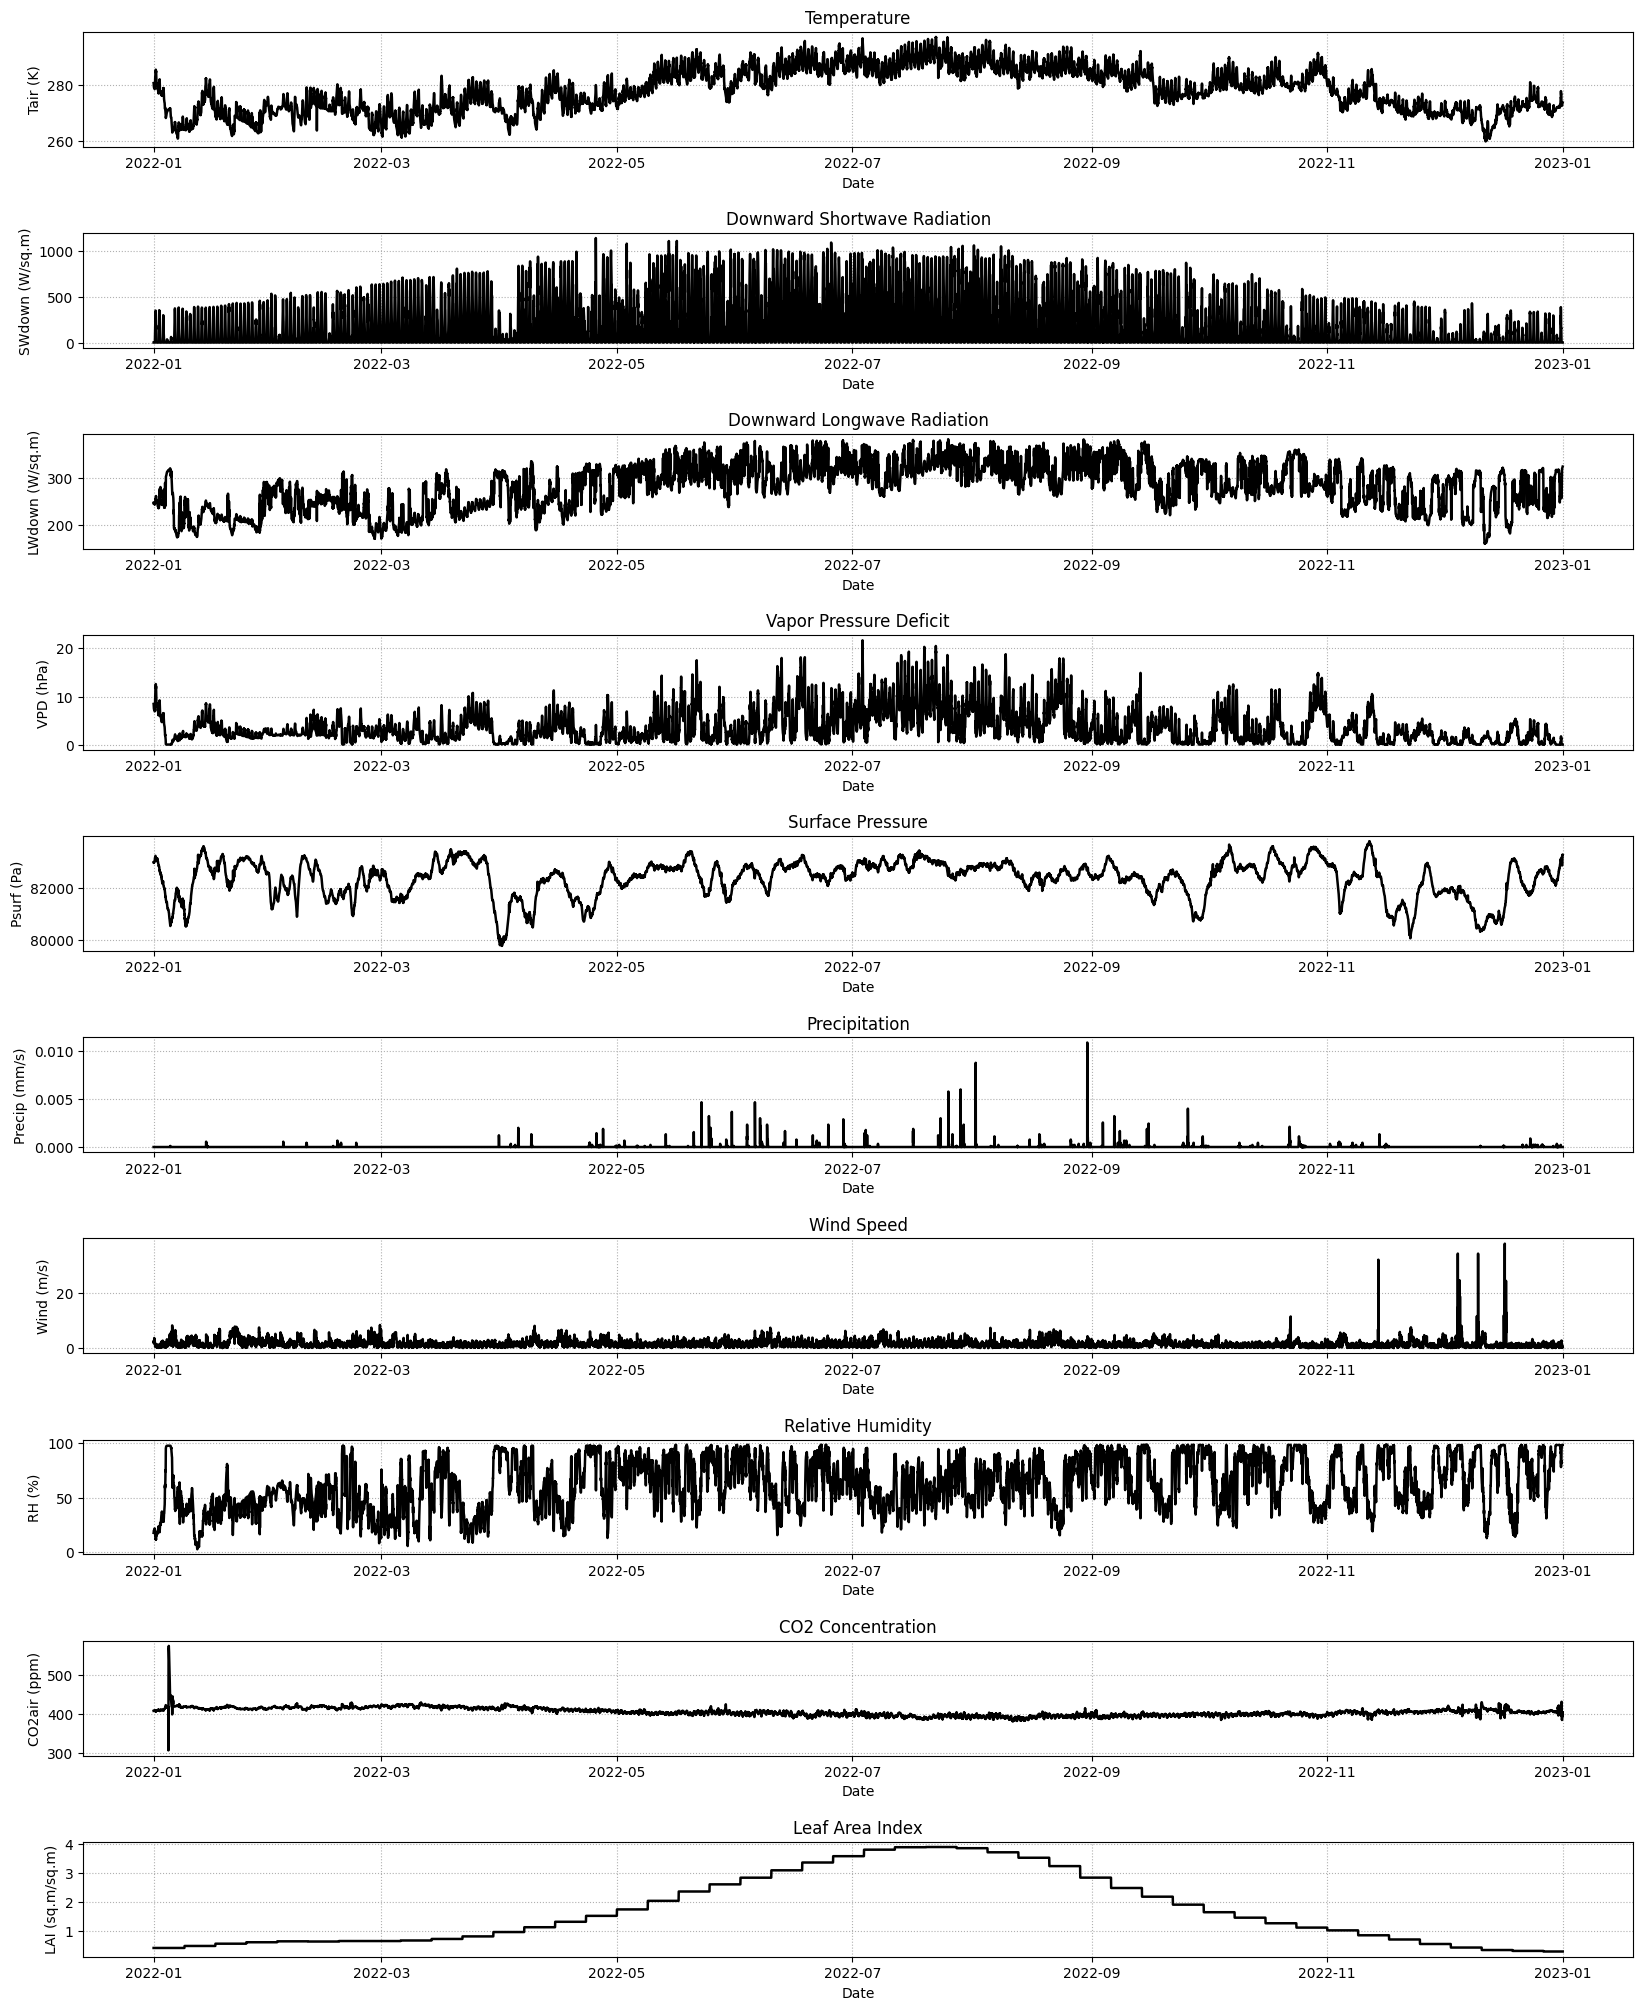

In [54]:
# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 2.5 * num_rows))

# Flatten the axes array for easier iteration
axes_flat = axes.flatten()

# Iterate over variables and plot them
for i, var in enumerate(variables_to_plot):
    if var in ds_forcing:
        # Get the subplot for the current variable
        ax = axes_flat[i]

        # Plot the variable
        ax.plot(ds_forcing.time.values.flatten(), ds_forcing[var].values.flatten(),
                linestyle='-',
                linewidth=1.8,
                color='black',
                label=var)

        # Set the title, xlabel, ylabel, and grid
        ax.set_title(f"{variable_info[var]['title']}")
        ax.set_xlabel("Date")
        # Set the ylabel concatenating title and unit
        ax.set_ylabel(f"{var} ({variable_info[var]['unit']})")
        ax.grid(linestyle='dotted')
    else:
        # Hide the axis if the variable is not in the dataset
        axes_flat[i].axis('off')

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.75)
# Show the plot
plt.show()


## Reading MODIS and ECOSTRESS LST and comparing with model output

In [7]:
ds_forcing = xr.open_dataset("/home/khanalp/data/processed/input_pystemmus/v2/FLX_IT-Ren_FLUXNET2015_FULLSET_2022-2022.nc")

In [8]:
ds_forcing.latitude.values,ds_forcing.longitude.values

(array([[46.58686]], dtype=float32), array([[11.43369]], dtype=float32))

In [9]:
df_MODIS_LST = pd.read_csv('/home/khanalp/paper01/output/LSTMODIS/IT-Ren_2022.csv')
# df_ECOSTRESS_LST = pd.read_csv('/home/khanalp/ECOSTRESS/ECOSTRESS_DE-Tha_2022/De-Tha-2022-ECO-L2T-LSTE-002-results.csv')

In [10]:
df_MODIS_LST_filtered = df_MODIS_LST[df_MODIS_LST['LST_Day_C'].notna()]

In [11]:
from datetime import datetime, timedelta

# Helper function to convert float hours to HH:MM format
def float_to_hhmm(hour_float):
    try:
        td = timedelta(hours=hour_float)
        return (datetime.min + td).time().strftime('%H:%M')
    except:
        return None  # In case of NaN or invalid input
# Apply the conversion to the 'Day_view_time' and 'Night_view_time' columns
df_MODIS_LST_filtered.loc[:, 'Day_view_HHMM'] = df_MODIS_LST_filtered['Day_view_time'].apply(float_to_hhmm)
df_MODIS_LST_filtered.loc[:, 'Night_view_HHMM'] = df_MODIS_LST_filtered['Night_view_time'].apply(float_to_hhmm)


/home/khanalp/tmp/ipykernel_4062356/3832922551.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_filtered.loc[:, 'Day_view_HHMM'] = df_MODIS_LST_filtered['Day_view_time'].apply(float_to_hhmm)
/home/khanalp/tmp/ipykernel_4062356/3832922551.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_filtered.loc[:, 'Night_view_HHMM'] = df_MODIS_LST_filtered['Night_view_time'].apply(float_to_hhmm)


In [12]:
# Step 1: Ensure 'datetime' column is datetime type
df_MODIS_LST_filtered['datetime'] = pd.to_datetime(df_MODIS_LST_filtered['datetime'])

# Step 2: Add Day_view_time (float hours) as timedelta to datetime
df_MODIS_LST_filtered['timestamp'] = df_MODIS_LST_filtered['datetime'] + pd.to_timedelta(df_MODIS_LST_filtered['Day_view_time'], unit='h')

/home/khanalp/tmp/ipykernel_4062356/4105526546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_filtered['datetime'] = pd.to_datetime(df_MODIS_LST_filtered['datetime'])
/home/khanalp/tmp/ipykernel_4062356/4105526546.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_filtered['timestamp'] = df_MODIS_LST_filtered['datetime'] + pd.to_timedelta(df_MODIS_LST_filtered['Day_view_time'], unit='h')


In [13]:
# Step 4: Set either one as index
df_MODIS_LST_filtered = df_MODIS_LST_filtered.set_index('timestamp')

In [14]:
# df_ECOSTRESS_LST_filtered = df_ECOSTRESS_LST[df_ECOSTRESS_LST['ECO_L2T_LSTE_002_cloud'] == 0]

In [23]:
# df_ECOSTRESS_LST_filtered.Date

In [24]:
# # Step 1: Convert to datetime and set UTC timezone
# df_ECOSTRESS_LST_filtered['Date'] = pd.to_datetime(df_ECOSTRESS_LST_filtered['Date'], utc=True)

# # Step 2: Convert to Germany local time
# df_ECOSTRESS_LST_filtered['Date'] = df_ECOSTRESS_LST_filtered['Date'].dt.tz_convert('Europe/Berlin')


In [25]:
# df_ECOSTRESS_LST_filtered['Date']

In [26]:
# # Step 3: Set as index
# df_ECOSTRESS_LST_filtered = df_ECOSTRESS_LST_filtered.set_index('Date')

In [27]:
# # Remove the timezone info but KEEP a datetime index
# df_ECOSTRESS_LST_filtered.index = (
#     df_ECOSTRESS_LST_filtered.index.tz_localize(None)  # strip tz
# )

In [28]:
# # 1. Drop NaNs from the LST column
# df_ECOSTRESS_LST_filtered = df_ECOSTRESS_LST_filtered.dropna(subset=['ECO_L2T_LSTE_002_LST'])

# # 2. Convert from Kelvin to Celsius
# df_ECOSTRESS_LST_filtered['ECO_L2T_LSTE_002_LST'] = (
#     df_ECOSTRESS_LST_filtered['ECO_L2T_LSTE_002_LST'] - 273.15
# )


<Axes: xlabel='timestamp'>

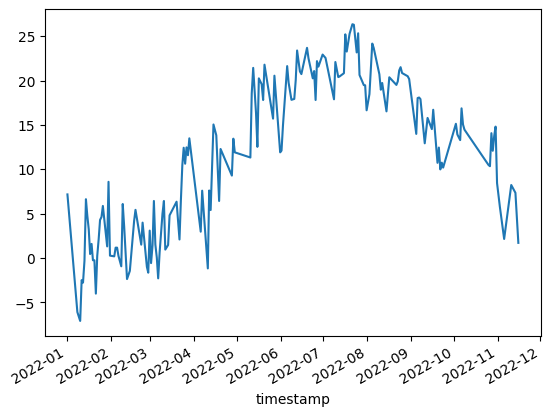

In [29]:
# df_ECOSTRESS_LST_filtered.ECO_L2T_LSTE_002_LST.plot()
df_MODIS_LST_filtered.LST_Day_C.plot()

# Reading model output

In [15]:
model_output_ml = "/home/khanalp/paper01/output/vMLWV/IT-Ren/"
model_output_bigleaf = "/home/khanalp/paper01/output/vbigleaf/IT-Ren"

In [16]:
# Read resistances, fluxes, and other files (rac, rlcu,etc.)
df_model_ML = pd.read_csv(os.path.join(model_output_ml, "anciliary_output.csv"))
df_model_bigleaf = pd.read_csv(os.path.join(model_output_bigleaf, "anciliary_output.csv"))
df_model_ML_fluxes = pd.read_csv(os.path.join(model_output_ml, "fluxes.csv"))
df_model_bigleaf_fluxes = pd.read_csv(os.path.join(model_output_bigleaf, "fluxes.csv"))

In [17]:
df_model_ML = df_model_ML.apply(pd.to_numeric, errors='coerce')
df_model_bigleaf = df_model_bigleaf.apply(pd.to_numeric, errors='coerce')
df_model_ML['time'] = pd.to_datetime(ds_forcing['time'].values.flatten())
df_model_bigleaf['time'] = pd.to_datetime(ds_forcing['time'].values.flatten())
df_model_ML.set_index('time', inplace=True)
df_model_bigleaf.set_index('time', inplace=True)

In [18]:
# Remove first row in case of fluxes
df_model_ML_fluxes = df_model_ML_fluxes.iloc[1:,]
df_model_bigleaf_fluxes = df_model_bigleaf_fluxes.iloc[1:,]

In [19]:
df_model_bigleaf_fluxes.lEtot.plot(color='blue', label='Bigleaf')
df_model_ML_fluxes.lEtot.plot(color = 'red', label='MLWV')


TypeError: no numeric data to plot

<Axes: xlabel='time'>

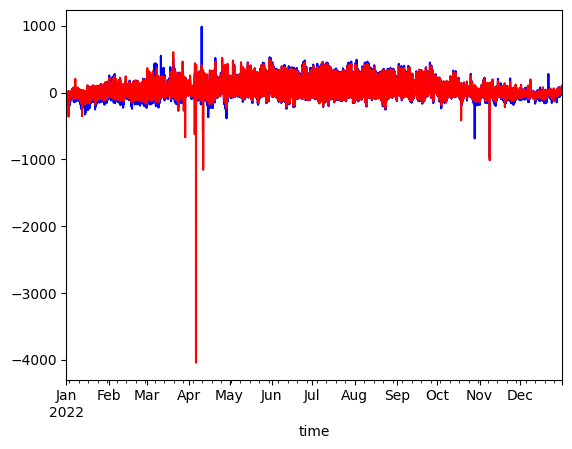

In [52]:
df_model_bigleaf_fluxes.Htot.plot(color='blue', label='Bigleaf')
df_model_ML_fluxes.Htot.plot(color = 'red', label='MLWV')


<Axes: xlabel='time'>

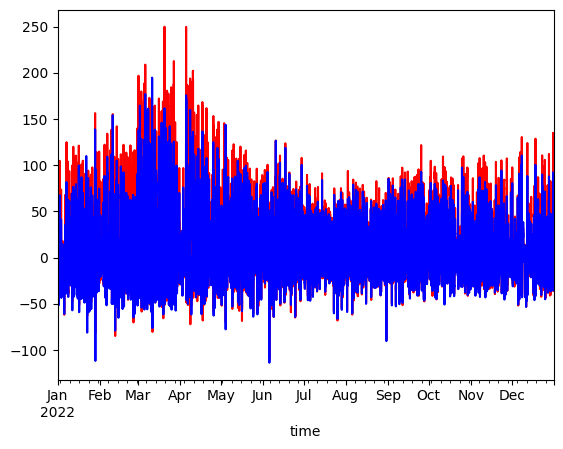

In [ ]:
df_model_ML_fluxes.Gtot.plot(color = 'red', label='MLWV')
df_model_bigleaf_fluxes.Gtot.plot(color='blue', label='Bigleaf')

In [34]:
df_model_ML_fluxes = df_model_ML_fluxes.apply(pd.to_numeric, errors='coerce')
df_model_bigleaf_fluxes = df_model_bigleaf_fluxes.apply(pd.to_numeric, errors='coerce')
df_model_ML_fluxes['time'] = pd.to_datetime(ds_forcing['time'].values.flatten())
df_model_bigleaf_fluxes['time'] = pd.to_datetime(ds_forcing['time'].values.flatten())
df_model_ML_fluxes.set_index('time', inplace=True)
df_model_bigleaf_fluxes.set_index('time', inplace=True)

In [35]:

def temperature_from_lw_out(lw_out: np.ndarray, lw_in:np.ndarray,emissivity: float) -> np.ndarray:
    """
    Calculate temperature (in Kelvin) from longwave radiation using the Stefan-Boltzmann law.

    Parameters:
        lw_out (np.ndarray or float): Outgoing longwave radiation in W/m²
        emissivity (float): Emissivity of the surface (0 < emissivity ≤ 1)

    Returns:
        np.ndarray: Temperature in Kelvin (same shape as input)
    """
    sigma = 5.670374419e-8  # W/m²/K⁴
    
    # Check emissivity is scalar and in valid range
    if not (0 < emissivity <= 1):
        raise ValueError("Emissivity must be in the range (0, 1].")
    
    lw_out = np.asarray(lw_out)
    lw_in = np.asarray(lw_in)
    if np.any(lw_out < 0):
        raise ValueError("LW_OUT values must be non-negative.")
    
    return ((lw_out -((1-emissivity) * lw_in))/ (emissivity * sigma)) ** 0.25


In [36]:
# GEt LST
# COmpute LST In degree C from LW_OUT
df_insitu_fluxnet['LST'] = temperature_from_lw_out(
    df_insitu_fluxnet['LW_OUT'].values,
    df_insitu_fluxnet['LW_IN_F'].values,
    emissivity=0.98
) - 273.15

In [34]:
poi_start = pd.to_datetime("2022-07-01 00:00:00")
poi_end = pd.to_datetime("2022-07-08 00:00:00")

In [35]:
# df_insitu_poi = df_insitu_fluxnet.loc[poi_start:poi_end]
df_model_ML_poi = df_model_ML.loc[poi_start:poi_end]
df_model_bigleaf_poi = df_model_bigleaf.loc[poi_start:poi_end]
df_MODIS_LST_poi = df_MODIS_LST_filtered.loc[poi_start:poi_end]

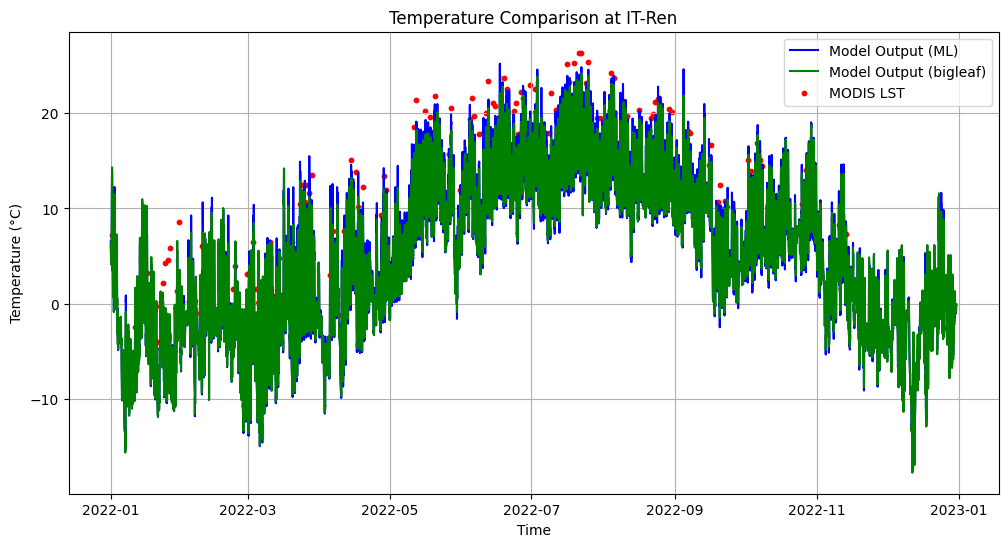

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(df_insitu_fluxnet.index, df_insitu_fluxnet['LST'], label='Insitu', color = 'black')

plt.plot(df_model_ML_poi.index, df_model_ML_poi['Tcave'], label='Model Output (ML)', color = 'blue')
plt.plot(df_model_bigleaf_poi.index, df_model_bigleaf_poi['Tcave'], label='Model Output (bigleaf)', color = 'green')

plt.scatter(df_MODIS_LST_poi.index, df_MODIS_LST_poi['LST_Day_C'], label='MODIS LST', color='red', s=10)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Comparison at {station}')
plt.legend()
plt.grid()
plt.show()

In [27]:
# For each MODIS timestamp, find index of closest timestamp in model_output
closest_in_model_pos = df_model_ML_poi.index.get_indexer(df_MODIS_LST_poi.index, method='nearest')

NameError: name 'df_model_ML_poi' is not defined

In [28]:
# Extract those closest model timestamps
closest_model_times = df_model_ML_poi.index[closest_in_model_pos]

# Optionally, add this info as a column to df_MODIS_LST_poi:
df_MODIS_LST_poi['closest_model_time'] = closest_model_times
df_MODIS_LST_poi['closest_model_time'] = pd.to_datetime(df_MODIS_LST_poi['closest_model_time'])
df_MODIS_LST_poi['LST_Day_C'] = pd.to_numeric(df_MODIS_LST_poi['LST_Day_C'], errors='coerce')

NameError: name 'df_model_ML_poi' is not defined

In [29]:
# Filter df_MODIS_LST_poi to only include rows where 'closest_model_time' exists in df_model_output.index
df_matched = df_MODIS_LST_poi[df_MODIS_LST_poi['closest_model_time'].isin(df_model_ML_poi.index)]

# Set 'closest_model_time' as the index to align with df_model_output
df_matched = df_matched.set_index('closest_model_time')

# Align both dataframes and create a new one
df_combined = pd.DataFrame({
    'Tcave_ML': df_model_ML.loc[df_matched.index, 'Tcave'],
    'Tcave_Bigleaf': df_model_bigleaf.loc[df_matched.index, 'Tcave'],
    'LST_Day_C': df_matched['LST_Day_C']
})


NameError: name 'df_MODIS_LST_poi' is not defined

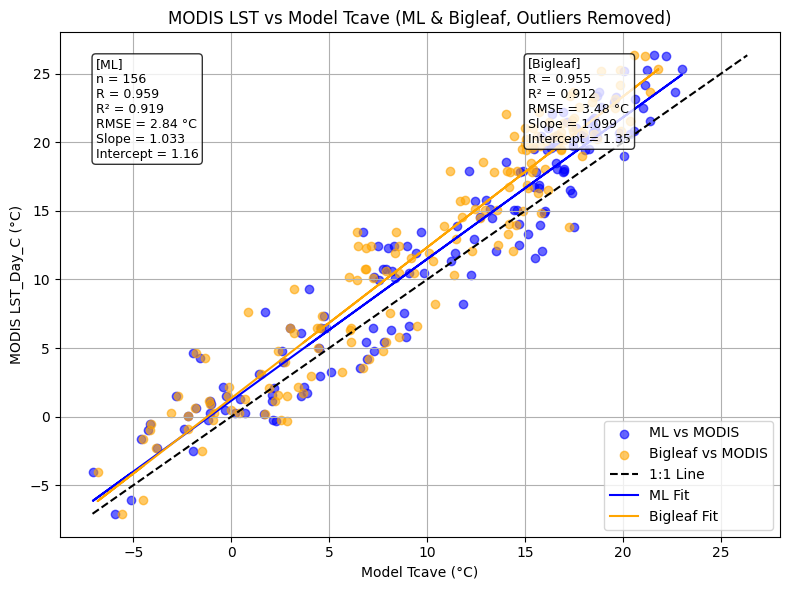

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress, pearsonr

# Step 1: Drop NaNs
df_clean = df_combined.dropna(subset=['Tcave_ML', 'Tcave_Bigleaf', 'LST_Day_C'])

# Step 2: Compute residuals for both models
df_clean['residual_ML'] = df_clean['LST_Day_C'] - df_clean['Tcave_ML']
df_clean['residual_Bigleaf'] = df_clean['LST_Day_C'] - df_clean['Tcave_Bigleaf']

# Step 3: Filter outliers (e.g., z-score < 2 for both)
z_ML = np.abs((df_clean['residual_ML'] - df_clean['residual_ML'].mean()) / df_clean['residual_ML'].std())
z_BL = np.abs((df_clean['residual_Bigleaf'] - df_clean['residual_Bigleaf'].mean()) / df_clean['residual_Bigleaf'].std())
df_filtered = df_clean[(z_ML < 2) & (z_BL < 2)]

# Extract variables
x_ml = df_filtered['Tcave_ML']
x_bl = df_filtered['Tcave_Bigleaf']
y = df_filtered['LST_Day_C']

# Stats for ML
n_ml = len(x_ml)
R_ml, _ = pearsonr(x_ml, y)
R2_ml = R_ml**2
rmse_ml = np.sqrt(mean_squared_error(y, x_ml))
slope_ml, intercept_ml, *_ = linregress(x_ml, y)

# Stats for Bigleaf
R_bl, _ = pearsonr(x_bl, y)
R2_bl = R_bl**2
rmse_bl = np.sqrt(mean_squared_error(y, x_bl))
slope_bl, intercept_bl, *_ = linregress(x_bl, y)

# Stats text
stats_text_ml = (
    f"[ML]\n"
    f"n = {n_ml}\n"
    f"R = {R_ml:.3f}\n"
    f"R² = {R2_ml:.3f}\n"
    f"RMSE = {rmse_ml:.2f} °C\n"
    f"Slope = {slope_ml:.3f}\n"
    f"Intercept = {intercept_ml:.2f}"
)

stats_text_bl = (
    f"[Bigleaf]\n"
    f"R = {R_bl:.3f}\n"
    f"R² = {R2_bl:.3f}\n"
    f"RMSE = {rmse_bl:.2f} °C\n"
    f"Slope = {slope_bl:.3f}\n"
    f"Intercept = {intercept_bl:.2f}"
)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(x_ml, y, color='blue', alpha=0.6, label='ML vs MODIS')
plt.scatter(x_bl, y, color='orange', alpha=0.6, label='Bigleaf vs MODIS')

# 1:1 line
min_val = min(y.min(), x_ml.min(), x_bl.min())
max_val = max(y.max(), x_ml.max(), x_bl.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 Line')

# Regression lines
plt.plot(x_ml, slope_ml * x_ml + intercept_ml, 'blue', label='ML Fit')
plt.plot(x_bl, slope_bl * x_bl + intercept_bl, 'orange', label='Bigleaf Fit')

# Labels and titles
plt.xlabel('Model Tcave (°C)')
plt.ylabel('MODIS LST_Day_C (°C)')
plt.title('MODIS LST vs Model Tcave (ML & Bigleaf, Outliers Removed)')
plt.legend()
plt.grid(True)

# Add text boxes
plt.gca().text(0.05, 0.95, stats_text_ml, transform=plt.gca().transAxes,
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.gca().text(0.65, 0.95, stats_text_bl, transform=plt.gca().transAxes,
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


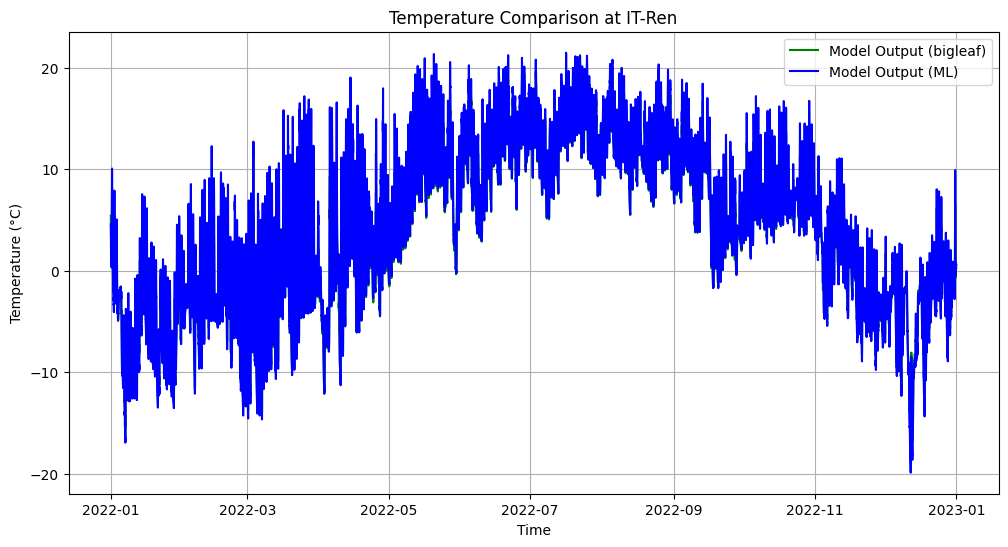

In [42]:

plt.figure(figsize=(12, 6))
# plt.plot(df_insitu_fluxnet.index, df_insitu_fluxnet['LST'], label='Insitu', color = 'black')
plt.plot(df_model_bigleaf.index, df_model_bigleaf['Tsave'], label='Model Output (bigleaf)', color = 'green')
plt.plot(df_model_ML.index, df_model_ML['Tsave'], label='Model Output (ML)', color = 'blue')

# plt.scatter(df_MODIS_LST_filtered.index, df_MODIS_LST_filtered['LST_Day_C'], label='MODIS LST', color='red', s=10)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Comparison at {station}')
plt.legend()
plt.grid()
plt.show()

In [43]:
df_model_ML_ST = pd.read_csv(os.path.join(model_output_ml, "Sim_Temp.csv"))
df_model_bigleaf_ST = pd.read_csv(os.path.join(model_output_bigleaf, "Sim_Temp.csv"))

/home/khanalp/tmp/ipykernel_723131/2256897522.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_model_ML_ST = pd.read_csv(os.path.join(model_output_ml, "Sim_Temp.csv"))
/home/khanalp/tmp/ipykernel_723131/2256897522.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_model_bigleaf_ST = pd.read_csv(os.path.join(model_output_bigleaf, "Sim_Temp.csv"))


In [23]:
df_ML_ST_selected = df_model_ML_ST.iloc[2:]
df_bigleaf_ST_selected = df_model_bigleaf_ST.iloc[2:]

NameError: name 'df_model_ML_ST' is not defined

In [24]:
df_ML_ST_selected = df_ML_ST_selected.apply(pd.to_numeric, errors='coerce')
df_bigleaf_ST_selected = df_bigleaf_ST_selected.apply(pd.to_numeric, errors='coerce')
df_ML_ST_selected['time'] = pd.to_datetime(ds_forcing['time'].values.flatten())
df_bigleaf_ST_selected['time'] = pd.to_datetime(ds_forcing['time'].values.flatten())
df_ML_ST_selected.set_index('time', inplace=True)
df_bigleaf_ST_selected.set_index('time', inplace=True)

NameError: name 'df_ML_ST_selected' is not defined

In [46]:
df_bigleaf_ST_poi = df_bigleaf_ST_selected.loc[poi_start:poi_end]
df_ML_ST_poi = df_ML_ST_selected.loc[poi_start:poi_end]
df_insitu_meteo_poi = df_insitu_meteo.loc[poi_start:poi_end]

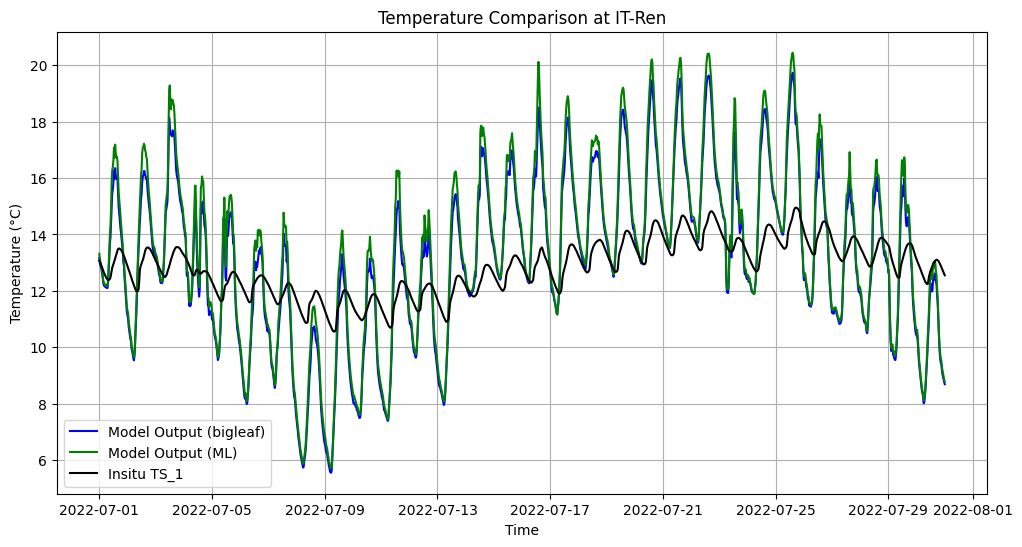

In [47]:
plt.figure(figsize=(12, 6))
# plt.plot(df_insitu_selected.index, df_insitu_selected['LST'], label='Insitu', color = 'black')
plt.plot(df_bigleaf_ST_poi.index, df_bigleaf_ST_poi['2'], label='Model Output (bigleaf)', color = 'blue')
plt.plot(df_ML_ST_poi.index, df_ML_ST_poi['2'], label='Model Output (ML)', color = 'green')
plt.plot(df_insitu_meteo_poi.index, df_insitu_meteo_poi['TS_1'], label='Insitu TS_1', color = 'black')

# plt.scatter(df_ECOSTRESS_LST_filtered.index, df_ECOSTRESS_LST_filtered['ECO_L2T_LSTE_002_LST'], label='MODIS LST', color='red', s=10)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Comparison at {station}')
plt.legend()
plt.grid()
plt.show()

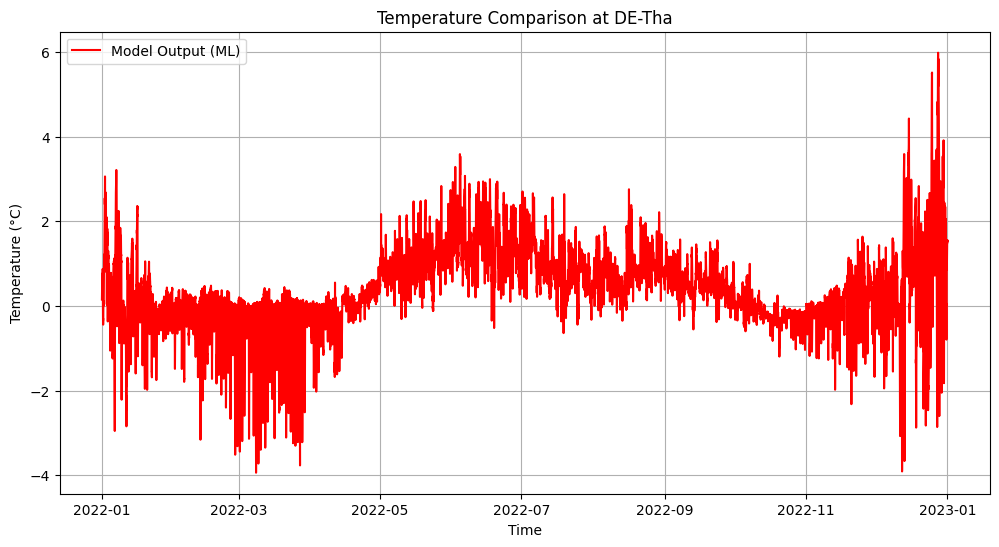

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(df_insitu_selected.index, df_insitu_selected['LST'], label='Insitu', color = 'black')
# plt.plot(df_model_bigleaf.index, df_model_bigleaf['Tsave'], label='Model Output (bigleaf)', color = 'blue')
# plt.plot(df_model_ML.index, df_model_ML['Tsave'], label='Model Output (ML)', color = 'green')
plt.plot(df_model_ML.index,df_model_bigleaf['Tsave'] - df_model_ML['Tsave'], label='Model Output (ML)', color = 'red')
plt.plot(df_insitu_meteo.index, df_insitu['TS_1'], label='Insitu TS_1', color = 'black')

# plt.scatter(df_ECOSTRESS_LST_filtered.index, df_ECOSTRESS_LST_filtered['ECO_L2T_LSTE_002_LST'], label='MODIS LST', color='red', s=10)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Comparison at {station}')
plt.legend()
plt.grid()
plt.show()

<Axes: xlabel='time'>

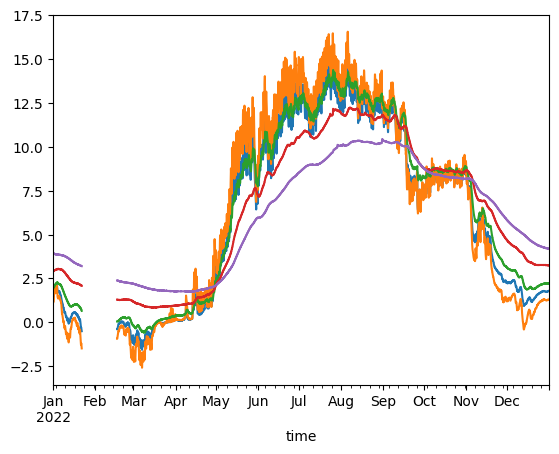

In [63]:
df_insitu_meteo.TS_1.plot()
df_insitu_meteo.TS_2.plot()
df_insitu_meteo.TS_3.plot()
df_insitu_meteo.TS_4.plot()
df_insitu_meteo.TS_5.plot()
# df_insitu_meteo.TS_6.plot()

<Axes: xlabel='time'>

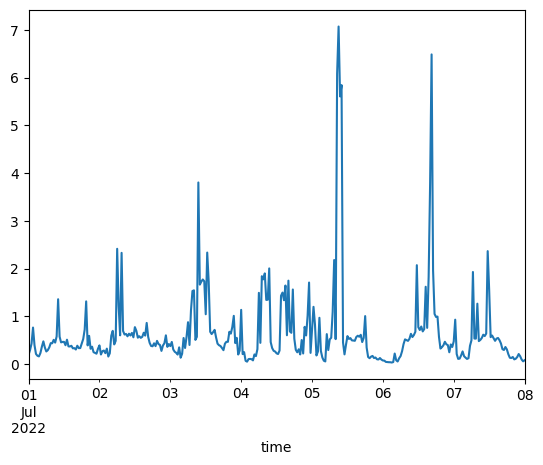

In [44]:
(df_model_ML_poi['rbssh'] - df_model_ML_poi['rbssu']).plot()

<Axes: xlabel='time'>

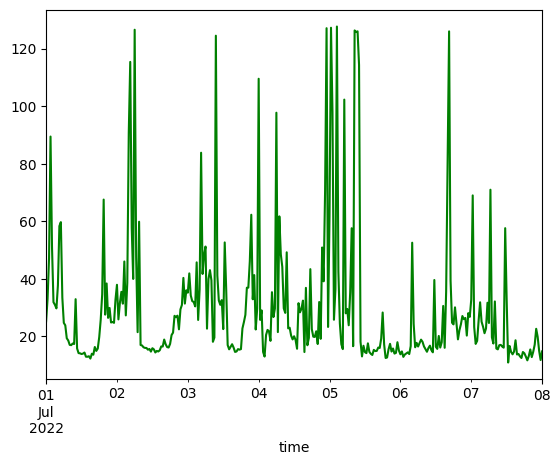

In [14]:
import pandas as pd
df = pd.read_csv('/home/khanalp/data/maunaloa_co2.csv')

In [16]:
df

,year,month,day,date,co2(ppm)
0,1974,5,19,1974.3781,333.46
1,1974,5,20,1974.3808,333.64
2,1974,5,21,1974.3836,333.50
3,1974,5,22,1974.3863,333.21
4,1974,5,23,1974.3890,333.05
...,...,...,...,...,...
15527,2025,1,8,2025.0192,426.23
15528,2025,1,9,2025.0219,426.26
15529,2025,1,10,2025.0247,426.02
15530,2025,1,11,2025.0274,426.77


In [17]:
df['time'] = pd.to_datetime(df[['year', 'month', 'day']])

In [18]:
df.set_index('time', inplace=True)

In [21]:
df_selected = df[['co2(ppm)']]

In [ ]:
# Resample the CO2 data to 30-minute intervals using forward fill to fill missing values
df_30min = df_selected.resample('30T').ffill()

,co2(ppm)
time,
1974-05-19 00:00:00,333.46
1974-05-19 00:30:00,333.46
1974-05-19 01:00:00,333.46
1974-05-19 01:30:00,333.46
1974-05-19 02:00:00,333.46


In [ ]:
df_30min_poi = df_30min.loc[pd.to_datetime("2000-01-01 00:00:00"):pd.to_datetime("2024-12-31 23:30:00")]

In [32]:
df_30min_poi.to_csv('/home/khanalp/data/manualoa_co2_30min_2000_2024.csv')

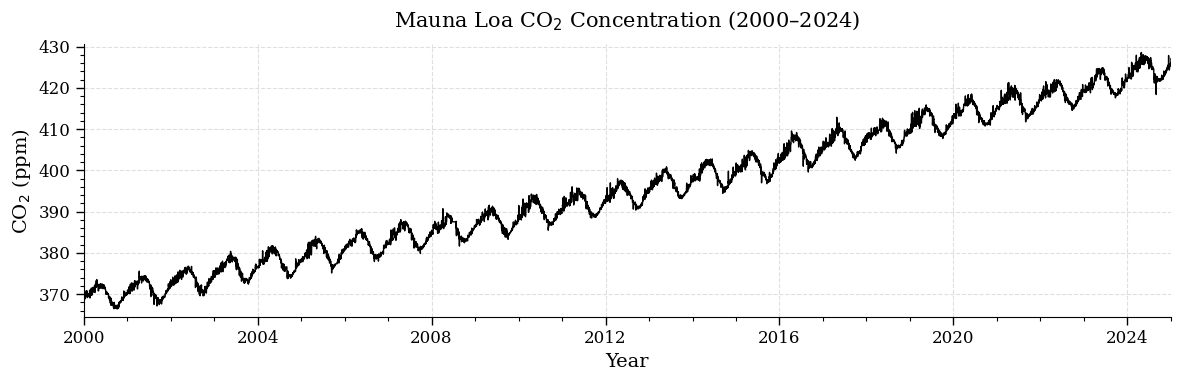

In [31]:
plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.family': 'serif', 'font.size': 13})

plt.plot(df_30min_poi.index, df_30min_poi['co2(ppm)'], color='black', linewidth=1)
plt.xlabel('Year', fontsize=14)
plt.ylabel('CO$_2$ (ppm)', fontsize=14)
plt.title('Mauna Loa CO$_2$ Concentration (2000–2024)', fontsize=15, pad=12)
plt.xlim(df_30min_poi.index.min(), df_30min_poi.index.max())
plt.ylim(df_30min_poi['co2(ppm)'].min() - 2, df_30min_poi['co2(ppm)'].max() + 2)
plt.grid(True, linestyle='--', alpha=0.4, linewidth=0.8)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', length=3, width=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()
